In [3]:
# Figure 4 plotter - photoferrotrophy incubation data
# Copyright Jackson M. Tsuji, Neufeld lab, 2019

In [4]:
import pandas as pd
from plotnine import *

In [34]:
# User variables
sample_concentrations_filepath = '../input_data/summary/Fe_incubation_plotting_data_191125_Fig_4.tsv'
sample_metadata_filepath = 'sample_metadata.tsv'
timepoint_metadata_filepath = 'timepoint_metadata.tsv'
output_pdf_filepath = 'Figure_04_raw.pdf'

In [20]:
# Load sample metadata
sample_metadata = pd.read_csv(sample_metadata_filepath, sep='\t')
sample_metadata.head()

,Sample_code,Sample_ID,Organism,Treatment,Rep_group,Rep
0,1,Media-U-A,Media control,Light + Fe(II),Media-U,A
1,2,Media-U-B,Media control,Light + Fe(II),Media-U,B
2,3,Media-E-A,Media control,Light + Fe(II) + EDTA,Media-E,A
3,4,Media-E-B,Media control,Light + Fe(II) + EDTA,Media-E,B
4,5,Chl1-DE-A,Ca. Chl. canadense,Fe(II) + EDTA (dark),Chl1-DE,A


In [21]:
# Load timepoint metadata
timepoint_metadata = pd.read_csv(timepoint_metadata_filepath, sep='\t')
timepoint_metadata = timepoint_metadata[['Timepoint_code', 'Incubation_duration_days']]
timepoint_metadata.head()

,Timepoint_code,Incubation_duration_days
0,tU,NaN
1,t0,0.000000
2,t1,0.354167
3,t2,0.833333
4,t3,1.395833


In [22]:
# Load concentration data
sample_concentrations = pd.read_csv(sample_concentrations_filepath, sep='\t')

# Clean up columns
sample_concentrations.rename(columns={'Treatment': 'Fe_fraction',
                                     'Ave_concentration': 'Fe_concentration_uM',
                                     'StdDev_concentration': 'Fe_concentration_sd_uM'}, inplace=True)
sample_concentrations = sample_concentrations[['Sample_name', 'Fe_fraction', 
                                               'Fe_concentration_uM', 'Fe_concentration_sd_uM']]

sample_concentrations.head()

,Sample_name,Fe_fraction,Fe_concentration_uM,Fe_concentration_sd_uM
0,t0_1,Fe2,100.741737,4.292506
1,t0_1,FeTot,107.462671,3.883696
2,t0_10,Fe2,61.716961,1.022025
3,t0_10,FeTot,102.403903,4.496911
4,t0_11,Fe2,55.285099,0.102203


In [23]:
# Calculate Fe(III)
# First, make the table wide format based on the Fe fraction
sample_concentrations_wide = sample_concentrations.pivot_table(values=['Fe_concentration_uM', 
                                                                       'Fe_concentration_sd_uM'],
                                  index=['Sample_name'],
                                  columns=['Fe_fraction'])

# Calculate Fe3 average and standard deviation
sample_concentrations_wide['Fe_concentration_uM', 'Fe3'] = sample_concentrations_wide['Fe_concentration_uM', 'FeTot'] - sample_concentrations_wide['Fe_concentration_uM', 'Fe2']
# See https://www.researchgate.net/post/How_do_I_add_subtract_one_standard_deviation_from_the_other, accessed 191121
sample_concentrations_wide['Fe_concentration_sd_uM', 'Fe3'] = sample_concentrations_wide['Fe_concentration_sd_uM', 'FeTot'] + sample_concentrations_wide['Fe_concentration_sd_uM', 'Fe2']
sample_concentrations_wide.head()

# Get rid of the multiindex that can cause problems during the melt
sample_concentrations_wide.reset_index(inplace=True)

In [24]:
# Convert back to long format
sample_concentrations = sample_concentrations_wide.melt(id_vars=['Sample_name'], 
                                       var_name=['Data_type', 'Fe_fraction'],
                                       value_name='uM')

# The above code makes the data too long. I need to get the ave and stddev as separate columns
sample_concentrations = sample_concentrations.pivot_table(values=['uM'],
                        index=['Sample_name', 'Fe_fraction'],
                        columns=['Data_type'])

# Get rid of the extraneous column level and bring the Sample_name and Fe_fraction back as columns
sample_concentrations.columns = sample_concentrations.columns.droplevel()
sample_concentrations.reset_index(inplace=True)

sample_concentrations.head()

Data_type,Sample_name,Fe_fraction,Fe_concentration_sd_uM,Fe_concentration_uM
0,t0_1,Fe2,4.292506,100.741737
1,t0_1,Fe3,8.176203,6.720934
2,t0_1,FeTot,3.883696,107.462671
3,t0_10,Fe2,1.022025,61.716961
4,t0_10,Fe3,5.518937,40.686942


In [25]:
# Split sample_name into sample_code and timepoint_code
sample_naming = sample_concentrations['Sample_name'].str.split(pat='_', expand=True)
sample_naming.rename(columns={0: 'Timepoint_code', 1: 'Sample_code'}, inplace=True)
sample_naming['Sample_code'] = sample_naming['Sample_code'].astype('int64')

sample_concentrations = pd.concat([sample_naming, sample_concentrations], axis=1)
sample_concentrations.drop(columns=['Sample_name'], inplace=True)

sample_concentrations.head()

,Timepoint_code,Sample_code,Fe_fraction,Fe_concentration_sd_uM,Fe_concentration_uM
0,t0,1,Fe2,4.292506,100.741737
1,t0,1,Fe3,8.176203,6.720934
2,t0,1,FeTot,3.883696,107.462671
3,t0,10,Fe2,1.022025,61.716961
4,t0,10,Fe3,5.518937,40.686942


In [26]:
# Bind on metadata
sample_concentrations = pd.merge(sample_concentrations, timepoint_metadata, how='left', on='Timepoint_code')
sample_concentrations = pd.merge(sample_concentrations, sample_metadata, how='left', on='Sample_code')

sample_concentrations.head()

,Timepoint_code,Sample_code,Fe_fraction,Fe_concentration_sd_uM,Fe_concentration_uM,Incubation_duration_days,Sample_ID,Organism,Treatment,Rep_group,Rep
0,t0,1,Fe2,4.292506,100.741737,0.0,Media-U-A,Media control,Light + Fe(II),Media-U,A
1,t0,1,Fe3,8.176203,6.720934,0.0,Media-U-A,Media control,Light + Fe(II),Media-U,A
2,t0,1,FeTot,3.883696,107.462671,0.0,Media-U-A,Media control,Light + Fe(II),Media-U,A
3,t0,10,Fe2,1.022025,61.716961,0.0,Chl1-LE-B,Ca. Chl. canadense,Light + Fe(II) + EDTA,Chl1-LE,B
4,t0,10,Fe3,5.518937,40.686942,0.0,Chl1-LE-B,Ca. Chl. canadense,Light + Fe(II) + EDTA,Chl1-LE,B


In [27]:
# Make specific sample groups for drawing lines in plotnine
sample_concentrations['group'] = sample_concentrations['Sample_ID'] + '_' + sample_concentrations['Fe_fraction']

# Change Fe2 to Fe(II) and Fe3 to Fe(III)
sample_concentrations['Fe_fraction'] = sample_concentrations['Fe_fraction'].str.replace('^Fe2$', 'Fe(II)')
sample_concentrations['Fe_fraction'] = sample_concentrations['Fe_fraction'].str.replace('^Fe3$', 'Fe(III)')

/home/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_errorbar : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


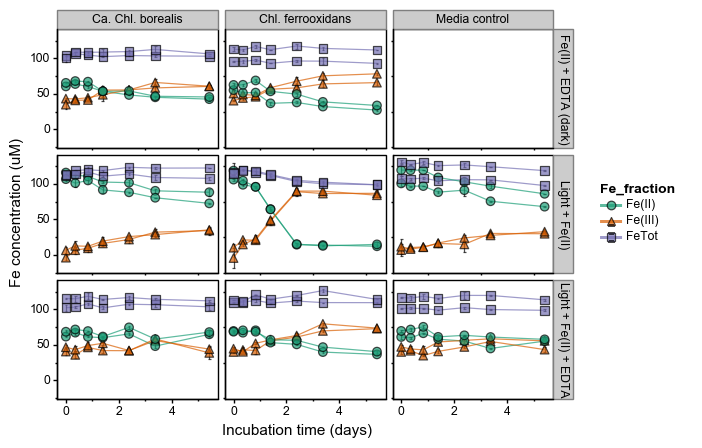

<ggplot: (8753293139576)>

In [32]:
Fe_plot = (ggplot(sample_concentrations, aes(x='Incubation_duration_days', y='Fe_concentration_uM'))
          + geom_line(aes(group='group', colour='Fe_fraction'), alpha=0.7)
          + geom_errorbar(aes(ymin='Fe_concentration_uM - Fe_concentration_sd_uM', 
                              ymax='Fe_concentration_uM + Fe_concentration_sd_uM'),
                         width=0.1, alpha=0.7)
          + geom_point(aes(fill='Fe_fraction', shape='Fe_fraction'), size=3, alpha=0.7)
          + facet_grid('Treatment ~ Organism')
          + scale_colour_brewer(type='qual', palette='Dark2')
          + scale_fill_brewer(type='qual', palette='Dark2')
          + theme_bw()
          + theme(panel_grid=element_blank(),
                  line=element_line(colour='black'),
                  panel_border=element_rect(colour='black'),
                  legend_title=element_text(size=10, face='bold'),
                  legend_key=element_blank(),
                  legend_key_height=5,
                  text=element_text(family='Arial', colour='black'))
          + xlab('Incubation time (days)')
          + ylab('Fe concentration (uM)'))

Fe_plot

In [35]:
Fe_plot.save(filename=output_pdf_filepath, width=150, height=150, units='mm')

/home/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 150.0 x 150.0 mm image.
  from_inches(height, units), units), PlotnineWarning)
/home/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: pdf/Fe_incubation_plot_191125_vs1c_FINAL.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)
/home/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_errorbar : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
